# Проект QA

## Yes/No Questions

Вы будете работать с корпусом BoolQ. Корпус состоит из вопросов, предполагающих бинарный ответ (да / нет), абзацев из Википедии,  содержащих ответ на вопрос, заголовка статьи, из которой извлечен абзац и непосредственно ответа (true / false).

Корпус описан в статье:

Christopher Clark, Kenton Lee, Ming-Wei Chang, Tom Kwiatkowski, Michael Collins, Kristina Toutanova
BoolQ: Exploring the Surprising Difficulty of Natural Yes/No Questions

https://arxiv.org/abs/1905.10044


Корпус (train-dev split) доступен в репозитории проекта:  https://github.com/google-research-datasets/boolean-questions

Используйте для обучения train часть корпуса, для валидации и тестирования – dev часть. 

Каждый бонус пункт оцениватся в 1 балл. Вывод являяется обязательным!

In [1]:
!gsutil cp gs://boolq/train.jsonl .
!gsutil cp gs://boolq/dev.jsonl .

Copying gs://boolq/train.jsonl...
/ [1 files][  6.2 MiB/  6.2 MiB]                                                
Operation completed over 1 objects/6.2 MiB.                                      
Copying gs://boolq/dev.jsonl...
/ [1 files][  2.1 MiB/  2.1 MiB]                                                
Operation completed over 1 objects/2.1 MiB.                                      


### Пример вопроса: 
question: is batman and robin a sequel to batman forever

title: Batman & Robin (film)

answer: true

passage: With the box office success of Batman Forever in June 1995, Warner Bros. immediately commissioned a sequel. They hired director Joel Schumacher and writer Akiva Goldsman to reprise their duties the following August, and decided it was best to fast track production for a June 1997 target release date, which is a break from the usual 3-year gap between films. Schumacher wanted to homage both the broad camp style of the 1960s television series and the work of Dick Sprang. The storyline of Batman & Robin was conceived by Schumacher and Goldsman during pre-production on A Time to Kill. Portions of Mr. Freeze's back-story were based on the Batman: The Animated Series episode ''Heart of Ice'', written by Paul Dini.

# Соображения по методологии

# Проведение одного эксперимента
1. Подбирайте гиперпараметры! Это довольно важно. Гиперпараметры --- это размеры слоёв, например. Хотя бы в одном эксперименте это стоит сделать честно, в остальных экспериментах в принципе можно предполагать, что в предыдущем эксперименте оптимальные размеры модели уже найдены.
2. Часто вам придётся скачивать предобученные веса (вроде BERT или RoBERTa) и дообучать дополнительные веса. В таком случае стоит попробовать несколько разных подходов:
* обучать только новые (головные) слои 
* обучать совместно всю модель
* сначала обучить головные слои, потом дофайнтьюнить веса всей модели
3. Фиксируйте лучшие результаты на валидационной выборке, по валидационной же выборке останавливайте обучение
4. Графики, графики, графики
5. Делайте промежуточные выводы

# Общие соображения
1. Один эксперимент --- одно изменение! Вы не представляете, насколько это важно. Пример: для эксперимента с моделью 1 Петя для получения эмбеддингов скачал предобученные веса BERT, а для эксперимента с моделью 2 -- предобученные веса RoBERTa. Вторая модель оказалась лучше, и Петя подумал, что архитектура второй модели лучше. Но, оказывается, с весами RoBERTa модель 1 работала бы не менее хорошо. 
2. Всегда сравнивайте результаты эксперимента с результатами всех остальных экспериментов и делайте промежуточные выводы. ***Это самый важный пункт!***
3. Не забывайте протестировать модель на адекватность. Для этого нужно задавать ей реальные вопросы и смотреть на ответы. Вопросы не должны быть элементами обучающей выборки!


## Часть 1. Эксплоративный анализ (1 балл)

In [1]:
import pandas as pd  

df_train = pd.read_json('train.jsonl', lines=True)
print(df_train.shape)
df_train.head()

(9427, 4)


,question,title,answer,passage
0,do iran and afghanistan speak the same language,Persian language,True,"Persian (/ˈpɜːrʒən, -ʃən/), also known by its ..."
1,do good samaritan laws protect those who help ...,Good Samaritan law,True,Good Samaritan laws offer legal protection to ...
2,is windows movie maker part of windows essentials,Windows Movie Maker,True,Windows Movie Maker (formerly known as Windows...
3,is confectionary sugar the same as powdered sugar,Powdered sugar,True,"Powdered sugar, also called confectioners' sug..."
4,is elder scrolls online the same as skyrim,The Elder Scrolls Online,False,As with other games in The Elder Scrolls serie...


In [2]:
df_dev = pd.read_json('dev.jsonl', lines=True) 
print(df_dev.shape)
df_dev.head()

(3270, 4)


,question,title,answer,passage
0,does ethanol take more energy make that produces,Ethanol fuel,False,All biomass goes through at least some of thes...
1,is house tax and property tax are same,Property tax,True,Property tax or 'house tax' is a local tax on ...
2,is pain experienced in a missing body part or ...,Phantom pain,True,Phantom pain sensations are described as perce...
3,is harry potter and the escape from gringotts ...,Harry Potter and the Escape from Gringotts,True,Harry Potter and the Escape from Gringotts is ...
4,is there a difference between hydroxyzine hcl ...,Hydroxyzine,True,Hydroxyzine preparations require a doctor's pr...


1. Посчитайте долю yes и no классов в корпусе

In [ ]:
df_train['answer'].value_counts()

True     5874
False    3553
Name: answer, dtype: int64

In [ ]:
df_dev['answer'].value_counts()

True     2033
False    1237
Name: answer, dtype: int64

И в обучающей части данных, и в тестовой части доля ответов "True" - чуть больше 60%, а "False" - чуть меньше 40%.

2. Оцените среднюю длину вопроса

In [4]:
question_len_train = df_train['question'].map(lambda x: len(list(x.split())))
print('question_mean_train: ', round(question_len_train.mean()))
print('question_max_train: ', max(question_len_train))

question_mean_train:  9
question_max_train:  21


In [5]:
question_len_dev = df_dev['question'].map(lambda x: len(list(x.split())))
print('question_mean_dev: ', round(question_len_dev.mean()))
print('question_max_dev: ', max(question_len_dev))

question_mean_dev:  9
question_max_dev:  17


Средняя длина вопроса - 9 слов и для трейн-данных, и для тестовых данных.

3. Оцените среднюю длину параграфа

In [6]:
passage_len_train = df_train['passage'].map(lambda x: len(list(x.split())))
print('passage_mean_train: ', round(passage_len_train.mean()))
print('passage_max_train: ', max(passage_len_train))

passage_mean_train:  93
passage_max_train:  754


In [7]:
passage_len_dev = df_dev['passage'].map(lambda x: len(list(x.split())))
print('passage_mean_dev: ', round(passage_len_dev.mean()))
print('passage_max_dev: ', max(passage_len_dev))

passage_mean_dev:  92
passage_max_dev:  813


Средняя длина параграфа - 93 слова для обучающей части, и 92 слова для тестовой части.

4. Предположите, по каким эвристикам были собраны вопросы (или найдите ответ в статье). Продемонстриуйте, как эти эвристики повлияли на структуру корпуса.

Эвристики: "Queries that are likely to be yes/no questions are heuristically identified: we found selecting queries where the first word is in a manually constructed set of indicator words (The full set is: {“did”, “do”, “does”, “is”, “are”, “was”,
“were”, “have”, “has”, “can”, “could”, “will”, “would”}) and are of sufficient length, to be effective. Questions are only kept if a Wikipedia page is returned as one of the first five results, in which case the question and Wikipedia page are given to a human annotator for further processing. The queries are typically short (average length 8.9 tokens)"

In [8]:
indicator_words = ['did', 'do', 'does', 'is', 'are', 'was', 'were', 'have', 'has', 'can', 'could', 'will', 'would']
count_indicator_words = df_train['question'].map(lambda x: list(x.split())[0] in indicator_words)
sum(count_indicator_words)

9022

Действительно, 9022 вопроса в трейн корпусе начинаются с глаголов из списка indicator_words. Посмотрим на несколько вопросов, которые начинаются с других слов.

In [ ]:
count_indicator_words[:21]

0      True
1      True
2      True
3      True
4      True
5      True
6      True
7      True
8      True
9      True
10     True
11     True
12     True
13    False
14     True
15     True
16     True
17     True
18     True
19    False
20    False
Name: question, dtype: bool

In [ ]:
print(df_train['question'][13])
print(df_train['question'][19])
print(df_train['question'][20])

calcium carbide cac2 is the raw material for the production of acetylene
the boy in the plastic bubble based on true story
science begins with the premise that knowledge should first be acquired through observation


Видно, что те вопросы, которые не начинаются со слов из списа indicator_words являются утвердительными предложениями, правильность которых необходимо проверить.

In [ ]:
question_len_train.value_counts()

8     4975
9     2303
10    1075
11     466
12     202
7      171
13      95
14      52
6       27
16      25
15      18
18       6
17       6
21       3
5        2
4        1
Name: question, dtype: int64

Что касается длины вопросов, то примерно 88% вопросов сосредоточены вокруг среднего значения и имеют длину в 8, 9 или 10 слов. 

## Часть 2. Baseline (1 балл)

1. Оцените accuracy точность совсем простого базового решения: присвоить каждой паре вопрос-ответ в dev части самый частый класс из train части

In [3]:
from sklearn.metrics import accuracy_score

In [ ]:
y_true = df_dev['answer'].replace(to_replace='True', value=1)
y_pred = y_true.map(lambda x: 1)
accuracy_score(y_true, y_pred)

0.6217125382262997

Решение присвоить самый частый ответ (True) дает точность в 62% - доля таких ответов и в трейн-части, и в тест части. 

2. Оцените accuracy чуть более сложного базового решения: fasttext на текстах, состоящих из склееных вопросов и абзацев (' '.join([question, passage]))

In [4]:
# предобработка данных

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('snowball_data')
nltk.download('perluniprops')
nltk.download('universal_tagset')
nltk.download('stopwords')
nltk.download('nonbreaking_prefixes')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

import re
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from tqdm import tqdm, tqdm_notebook

tqdm.pandas()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package snowball_data to /root/nltk_data...
[nltk_data] Downloading package perluniprops to /root/nltk_data...
[nltk_data]   Unzipping misc/perluniprops.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package nonbreaking_prefixes to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping corpora/nonbreaking_prefixes.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nlt

In [5]:
# склеиваем вопрос и ответ
df_train['question + passage'] = df_train['question'] + " " + df_train['passage']
df_dev['question + passage'] = df_dev['question'] + " " + df_dev['passage']

In [6]:
# удаляем лишние символы
df_train['tokens'] = df_train.progress_apply(lambda row: re.sub("[^A-zА-я0-9\s]", ' ', row['question + passage']), axis=1)
df_dev['tokens'] = df_dev.progress_apply(lambda row: re.sub("[^A-zА-я0-9\s]", ' ', row['question + passage']), axis=1)

100%|██████████| 3270/3270 [00:00<00:00, 23172.21it/s]


In [7]:
df_train['tokens'][0] # появился мусор в виде одиночных букв и слогов

'do iran and afghanistan speak the same language Persian    p  r  n     n    also known by its endonym Farsi        f rsi  f    si     listen    is one of the Western Iranian languages within the Indo Iranian branch of the Indo European language family  It is primarily spoken in Iran  Afghanistan  officially known as Dari since 1958   and Tajikistan  officially known as Tajiki since the Soviet era   and some other regions which historically were Persianate societies and considered part of Greater Iran  It is written in the Persian alphabet  a modified variant of the Arabic script  which itself evolved from the Aramaic alphabet '

In [8]:
# приводим текст к нижнему регистру
df_train['tokens'] = df_train.tokens.progress_apply(lambda row: row.lower())
df_dev['tokens'] = df_dev.tokens.progress_apply(lambda row: row.lower())

# df_train['tokens'] = df_train['question + passage'].progress_apply(lambda row: row.lower())
# df_dev['tokens'] = df_dev['question + passage'].progress_apply(lambda row: row.lower())

100%|██████████| 3270/3270 [00:00<00:00, 439722.17it/s]


In [9]:
df_train['tokens'][0]

'do iran and afghanistan speak the same language persian    p  r  n     n    also known by its endonym farsi        f rsi  f    si     listen    is one of the western iranian languages within the indo iranian branch of the indo european language family  it is primarily spoken in iran  afghanistan  officially known as dari since 1958   and tajikistan  officially known as tajiki since the soviet era   and some other regions which historically were persianate societies and considered part of greater iran  it is written in the persian alphabet  a modified variant of the arabic script  which itself evolved from the aramaic alphabet '

In [10]:
# токенизируем
df_train['tokens'] = df_train.tokens.progress_apply(lambda row: word_tokenize(row))   
df_dev['tokens'] = df_dev.tokens.progress_apply(lambda row: word_tokenize(row)) 

100%|██████████| 3270/3270 [00:01<00:00, 2171.52it/s]


In [11]:
len(df_train['tokens'][0])

101

In [12]:
# # оставляем уникальные токены 
df_train['tokens'] = df_train.tokens.progress_apply(lambda row: list(set(row)))
df_dev['tokens'] = df_dev.tokens.progress_apply(lambda row: list(set(row))) 

100%|██████████| 3270/3270 [00:00<00:00, 55481.33it/s]


In [13]:
len(df_train['tokens'][0])

68

In [14]:
from nltk.corpus import stopwords

stopWords = set(stopwords.words('english'))

In [15]:
# # удаляем стопслова и слова меньше 2 букв
df_train['tokens'] = df_train.tokens.progress_apply(lambda row: [x for x in row if x not in stopWords and len(x)>1])
df_dev['tokens'] = df_dev.tokens.progress_apply(lambda row: [x for x in row if x not in stopWords and len(x)>1])

# удаляем только токены меньше 2 букв
# df_train['tokens'] = df_train.tokens.progress_apply(lambda row: [x for x in row if len(x)>1])
# df_dev['tokens'] = df_dev.tokens.progress_apply(lambda row: [x for x in row if len(x)>1])

100%|██████████| 3270/3270 [00:00<00:00, 64759.31it/s]


In [16]:
len(df_train['tokens'][0])

46

In [17]:
# сопоставление POS-тегов NLTK с форматом, принятым лемматизатором wordnet
# для дальнейшей успешной лемматизации

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [18]:
# лемматизация
wnl = nltk.WordNetLemmatizer()
df_train['tokens'] = df_train.tokens.progress_apply(lambda row:[wnl.lemmatize(word, get_wordnet_pos(word)) for word in row])
df_dev['tokens'] = df_dev.tokens.progress_apply(lambda row:[wnl.lemmatize(word, get_wordnet_pos(word)) for word in row])

100%|██████████| 3270/3270 [00:25<00:00, 128.08it/s]


In [19]:
# # оставляем уникальные леммы
df_train['tokens'] = df_train.tokens.progress_apply(lambda row: list(set(row)))
df_dev['tokens'] = df_dev.tokens.progress_apply(lambda row: list(set(row))) 

100%|██████████| 3270/3270 [00:00<00:00, 131080.77it/s]


In [20]:
len(df_train['tokens'][0])

45

In [21]:
# соединяем токены обратно в предложения
df_train['tokens'] = df_train.tokens.progress_apply(lambda row:' '.join([word for word in row])) 
df_dev['tokens'] = df_dev.tokens.progress_apply(lambda row:' '.join([word for word in row]))

100%|██████████| 3270/3270 [00:00<00:00, 117282.56it/s]


In [22]:
df_train['tokens'][0]

'soviet speak farsi within era language alphabet since officially european primarily iranian iran script part historically endonym western persianate branch consider spoken tajiki arabic evolve afghanistan also write tajikistan region great family si modify one indo variant listen dari rsi persian 1958 aramaic know society'

In [23]:
# Готовим данные для модели

# сделаем лейблы в таком виде, который принимает fastText
df_fastText_train = pd.DataFrame(df_train.answer.progress_apply(lambda row: '__label__' + str(row)))
df_fastText_dev = pd.DataFrame(df_dev.answer.progress_apply(lambda row: '__label__' + str(row)))

# предобработанный текст
df_fastText_train['text'] = df_train['tokens']
df_fastText_dev['text'] = df_dev['tokens']

# текст без обработки
# df_fastText_train['text'] = df_train['question + passage']
# df_fastText_dev['text'] = df_dev['question + passage']

100%|██████████| 3270/3270 [00:00<00:00, 582047.79it/s]


In [24]:
df_fastText_train.head()

,answer,text
0,__label__True,soviet speak farsi within era language alphabe...
1,__label__True,incapacitate rescue otherwise wrongful volunta...
2,__label__True,software essential suite create ability part e...
3,__label__True,confectioner coffee clump small finely ice ant...
4,__label__False,progress steal three around time realm capture...


In [25]:
df_fastText_train.text[0]

'soviet speak farsi within era language alphabet since officially european primarily iranian iran script part historically endonym western persianate branch consider spoken tajiki arabic evolve afghanistan also write tajikistan region great family si modify one indo variant listen dari rsi persian 1958 aramaic know society'

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
import csv

df_fastText_train.to_csv(r'/gdrive/My Drive/df_fastText_train.txt', index=False, 
                    sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ")

In [ ]:
!pip install fastText

     |████████████████████████████████| 68 kB 3.8 MB/s 
  Using cached pybind11-2.9.0-py2.py3-none-any.whl (210 kB)
  Created wheel for fastText: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3131560 sha256=7ff1574670ff765e431027b8a0a9460e09eb7926898f3d918e30d4d8272f5627
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fastText


In [ ]:
import fasttext

model = fasttext.train_supervised(input='/gdrive/My Drive/data_fastText_train.txt', epoch=10, lr=0.1)

In [ ]:
def predict(row):
    return model.predict(row['text'])
predictions = df_fastText_dev.apply(predict, axis=1)
predictions = [x[0][0] for x in predictions]

accuracy_score(df_fastText_dev['answer'], predictions)

# с обработкой текста
# 0.6314984709480123 - epoch=5, lr=0.1, перебор числа эпох и lr не привели к улучшению скора, токены без выбора уникальных токенов
# 0.6253822629969419 - epoch=5, lr=0.1, только уникальные токены
# 0.6061162079510704 - epoch=5, lr=0.1, без убирания стоп-слов
# 0.6495412844036698 - epoch=10, lr=0.1, токены без лемматизации
# 0.6587155963302752 - epoch=10, lr=0.1, lowercase

# без предобработки текста
# 0.6428134556574924 -epoch=5, lr=0.1, 
# 0.673394495412844 - epoch=10, lr=0.1 - МАКСИМУМ!
# 0.6654434250764526 - epoch=10, lr=0.2
# 0.6470948012232416 - epoch=10, lr=0.05
# 0.67217125382263 - epoch=15
# 0.6694189602446483 - epoch=13
# 0.6712538226299695 - epoch=9
# 0.6688073394495413 - epoch=11
# 0.6703363914373088 - epoch=20

0.6587155963302752

fasttext показал лучше качество, чем константный алгоритм - 0.6734 против 0.6217. fasttextна данных без предобработки текста работает лучше, чем с предобработкой. Вероятно, так происходит потому, что при различных видах предобработки вместе с мусором удаляются и те токены, которые несут смысловую информацию. 


Почему fasttext плохо справляется с этой задачей?

Потому что fasttext не учитывает порядок и связи между токенами, т.к. вектор предложения/документа получается путем усреднения эмбеддингов слов/n-грамм. Под капотом у fasttext - логистическая регрессия, эта модель простая и не видит смыслов вопроса и параграфа.

## Часть 3. Используем эмбеддинги предложений (2 балла)
1. Постройте BERT эмбеддинги вопроса и абзаца. Обучите логистическую регрессию на конкатенированных эмбеддингах вопроса и абзаца и оцените accuracy этого решения. 

[bonus] Используйте другие модели эмбеддингов, доступные, например, в библиотеке 🤗 Transformers. Какая модель эмбеддингов даст лучшие результаты?

[bonus] Предложите метод аугментации данных и продемонстрируйте его эффективность. 

In [ ]:
# !pip install transformers

     |████████████████████████████████| 3.5 MB 4.3 MB/s 
     |████████████████████████████████| 6.8 MB 23.3 MB/s 
     |████████████████████████████████| 67 kB 5.0 MB/s 
     |████████████████████████████████| 895 kB 11.9 MB/s 
     |████████████████████████████████| 596 kB 54.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import numpy as np
import pandas as pd
import torch
import transformers as ppb
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# BERT 
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')
# model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-cased')

# DistilBERT
# model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
# model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-cased')

# BERT large
# model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-large-uncased')
# model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-large-cased')

# RoBERTa base
# model_class, tokenizer_class, pretrained_weights = (ppb.RobertaModel, ppb.RobertaTokenizer, 'roberta-base')

# RoBERTa large
# model_class, tokenizer_class, pretrained_weights = (ppb.RobertaModel, ppb.RobertaTokenizer, 'roberta-large')

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval();

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(i

In [ ]:
from torch.utils.data import Dataset, Subset

class QA_Dataset(Dataset):
    def __init__(self, question, passage, tokenizer, labels):
        self.labels = labels
        self.tokenized_question = [tokenizer.tokenize(string) for string in question]
        # 512 - the specified maximum sequence length for this model, 2 токена - cls и sep, 512-2=510
        self.tokenized_passage = [tokenizer.tokenize(string[:510]) for string in passage]
        
    def __getitem__(self, idx):
        return {"tokenized_question": self.tokenized_question[idx], "tokenized_passage": self.tokenized_passage[idx], "label": self.labels[idx]}

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset = QA_Dataset(df_train['question'].tolist(), df_train['passage'].tolist(), tokenizer, df_train['answer'].tolist()) 
dev_dataset = QA_Dataset(df_dev['question'].tolist(), df_dev['passage'].tolist(), tokenizer, df_dev['answer'].tolist())

In [ ]:
train_indices = [i for i in range(len(train_dataset))]
dev_indices = [i for i in range(len(dev_dataset))]

train_dataset = Subset(train_dataset, train_indices)
dev_dataset = Subset(dev_dataset, dev_indices)

# next(iter(train_dataset))

In [ ]:
from torch.utils.data import Sampler

class QA_Sampler(Sampler):
    def __init__(self, subset, batch_size=32):
        self.batch_size = batch_size
        self.subset = subset

        self.indices = subset.indices
        self.tokenized = np.array(subset.dataset.tokenized_passage)[self.indices]

    def __iter__(self):

        batch_idx = []
        # index in sorted data
        for index in np.argsort(list(map(len, self.tokenized))): # сортировка по длине
            batch_idx.append(index)
            if len(batch_idx) == self.batch_size:
                yield batch_idx
                batch_idx = []

        if len(batch_idx) > 0:
            yield batch_idx

    def __len__(self):
        return len(self.dataset)

In [ ]:
from torch.utils.data import DataLoader

def get_padded(values):
    max_len = 0
    for value in values:
        if len(value) > max_len:
            max_len = len(value)

    padded = np.array([value + [0]*(max_len-len(value)) for value in values])

    return padded

def collate_fn(batch):

    inputs_question = []
    inputs_passage = []
    labels = []
    for elem in batch:
        inputs_question.append(tokenizer.encode(elem['tokenized_question']))
        inputs_passage.append(tokenizer.encode(elem['tokenized_passage']))
        labels.append(elem['label'])

    inputs_question = get_padded(inputs_question) # padded inputs
    inputs_passage = get_padded(inputs_passage) # padded inputs
    attention_mask_question = np.where(inputs_question != 0, 1, 0)
    attention_mask_passage = np.where(inputs_passage != 0, 1, 0)

    return {"inputs_question": torch.tensor(inputs_question), "inputs_passage": torch.tensor(inputs_passage), 
            "labels": torch.FloatTensor(labels), 
            'attention_mask_question' : torch.tensor(attention_mask_question), 'attention_mask_passage' : torch.tensor(attention_mask_passage)}

In [ ]:
train_loader = DataLoader(train_dataset, batch_sampler=QA_Sampler(train_dataset), collate_fn=collate_fn)
test_loader = DataLoader(dev_dataset, batch_sampler=QA_Sampler(dev_dataset), collate_fn=collate_fn)

# next(iter(train_loader))

In [ ]:
from tqdm.notebook import tqdm

def get_xy(loader):
    features_question = []
    features_passage = []
    labels = []

    with torch.no_grad():
        for batch in tqdm(loader):

            inputs_question = batch["inputs_question"].to(device)
            attention_mask_question = batch['attention_mask_question'].to(device)
            inputs_passage = batch["inputs_passage"].to(device)
            attention_mask_passage = batch['attention_mask_passage'].to(device)

            last_hidden_states_question = model(inputs_question, attention_mask=attention_mask_question)
            last_hidden_states_passage = model(inputs_passage, attention_mask=attention_mask_passage)
            
            features_question.append(last_hidden_states_question[0].cpu())
            features_passage.append(last_hidden_states_passage[0].cpu())
            labels.append(batch['labels'])

    features_question = torch.cat([elem[:, 0, :] for elem in features_question], dim=0).numpy() # токен CLS
    features_passage = torch.cat([elem[:, 0, :] for elem in features_passage], dim=0).numpy()   # токен CLS
    labels = torch.cat(labels, dim=0).numpy()
    
    return features_question, features_passage, labels

In [ ]:
train_features_question, train_features_passage, train_labels = get_xy(train_loader)
test_features_question, test_features_passage, test_labels = get_xy(test_loader)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
train_features_question.shape, train_features_passage.shape

((9427, 768), (9427, 768))

In [ ]:
x_train = np.concatenate((train_features_question, train_features_passage), 1) # ((9427, 768), (9427, 768)) -> (9427, 1536)
x_test = np.concatenate((test_features_question, test_features_passage), 1)

In [ ]:
# lr_clf = LogisticRegression()
lr_clf = LogisticRegression(C=0.01, solver='newton-cg')
lr_clf.fit(x_train, train_labels)

pred = lr_clf.predict(x_test)
accuracy_score(test_labels, pred)

# BERT uncased
# 0.6495412844036698 - параметры по умолчанию
# 0.6501529051987768 - max_iter=500
# 0.6565749235474007 - max_iter=500, C=0.01

# BERT cased
# 0.6483180428134556 - параметры по умолчанию
# 0.6443425076452599 - max_iter=500, C=0.01

# DistilBERT uncased
# 0.6623853211009174 - параметры по умолчанию
# 0.6584097859327217 - max_iter=500
# 0.6605504587155964 - max_iter=500, C=0.1
# 0.6584097859327217 - max_iter=100, C=0.1, l1_ratio=0.6, penalty='elasticnet', solver='saga'
# 0.6587155963302752 - C=0.01, solver='newton-cg'

# DistilBERT cased
# 0.653211009174312 - параметры по умолчанию
# 0.6587155963302752 - C=0.1
# 0.6593272171253822 - max_iter=500, C=0.1

# BERT large uncased
# 0.6461773700305811 - параметры по умолчанию
# 0.6614678899082569 - C=0.01
# 0.6636085626911316 - max_iter=200, C=0.01 - MAX!!!
# 0.6577981651376147 - C=0.1, penalty='l1', solver='saga'
# 0.6571865443425077 - C=0.1, l1_ratio=0.8, penalty='elasticnet', solver='saga'

# BERT large cased
# 0.6400611620795107 - параметры по умолчанию
# 0.6529051987767585 - C=0.01
# 0.6519877675840978 - max_iter=300, C=0.01

# RoBERTa base
# 0.6232415902140673 - параметры по умолчанию
# 0.6290519877675841 - C=0.01

# RoBERTa large
# 0.636085626911315 - параметры по умолчанию
# 0.6327217125382263 - C=0.01
# 0.6370030581039755 - C=10

0.6587155963302752

In [ ]:
from sklearn.model_selection import GridSearchCV

# parameters = {'penalty':['l1', 'l2', 'elasticnet'],
            #  'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
            #              'max_iter':[100, 300], 
            #  'l1_ratio':[0.2, 0.4, 0.6, 0.8]}
parameters = {'C':[0.001, 0.01, 0.1, 1, 10],
              'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}


CV_LR_model = GridSearchCV(estimator=LogisticRegression(penalty='l2'), 
                        param_grid=parameters,
                        cv=3, 
                        scoring='accuracy',
                        n_jobs=-1, 
                        verbose=10)

CV_LR_model.fit(x_train, train_labels)             

Fitting 3 folds for each of 25 candidates, totalling 75 fits


GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='accuracy', verbose=10)

In [ ]:
CV_LR_model.best_estimator_

LogisticRegression(C=0.01, solver='newton-cg')

Логистическая регрессия, обученная на конкатенированных эмбеддингах вопроса и абзаца, дала лучший результат с эмбеддингами BERT large uncased - 0.6636. Этот результат чуть хуже, чем дал fasttext - 0.6734.
С логистической регрессией эмбеддинги uncased дают чуть лучше результаты (отличия во второй цифре после запятой), чем cased. 



## Часть 4. Обучаем BERT на конкатенации вопроса и предложения (2 балла)

В этой части предлагается реализовать фреймворк, описанный в [видео по ссылке](https://www.youtube.com/watch?v=l8ZYCvgGu0o), адаптировав его под бинарный Question Answering. 

1. Опишите модель, которую вы будете реализовывать. Загрузите предобученный BERT, добавьте полносвязные "головные" слои. Дообучите модель: попробуйте разные способы обучения.

[bonus] Используйте модель [RoBERTa](https://arxiv.org/abs/1907.11692) вместо модели BERT. Посмотрите, что получилось.

Модели - предобученные BERT/RoBERTa, с добавленными слоями классификатора. В классификатор передаем хидден_стейт, соответсвующий токену CLS последнего слоя. Если предобученная модель уже имеет собственные слои классификатора, то можно использовать их, или удалить их и добавить свой классификатор, и сравнить, какой подход работает лучше.

4 способа обучения:
1. Заморозить веса BERT/RoBERTa и использовать его для получения признаков, а учить только классификатор
2. Разморозить несколько последних слоев BERT/RoBERTa и учить их вместе с классификатором
3. Заморозить веса BERT/RoBERTa на первые несколько эпох, в это время учить только классификатор, потом разморозить BERT/RoBERTa и учить все вместе
4. Сразу учить и BERT/RoBERTa, и классификатор

In [12]:
# !pip install transformers

In [4]:
import numpy as np
import torch
import transformers as ppb
import torch.optim as optim
from torch import nn

In [5]:
# Переводим ответы из True/False в 1/0

df_train['answer'] = df_train['answer'].astype(int)
df_dev['answer'] = df_dev['answer'].astype(int)

### BertModel

In [6]:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')
tokenizer_Bert = tokenizer_class.from_pretrained(pretrained_weights)
model_Bert = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
class QA_Dataset_Bert(torch.utils.data.Dataset):
    def __init__(self, question, passage, labels, tokenizer, max_length=512):
        self.question = question
        self.passage = passage
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.labels = labels

    def __getitem__(self, idx):
  
        que = self.question[idx]
        pas = self.passage[idx]
        target = self.labels[idx]

        # 512 - the specified maximum sequence length for this model, 3 токена - cls и 2 sep, 512-3=509
        # почему-то выставления max_length в tokenizer.encode_plus было не достаточно, попадались батчи с последовательностями большей длины
        if len(self.tokenizer.tokenize(que)) + len(self.tokenizer.tokenize(pas)) > 509:
               pas = pas[:509-len(self.tokenizer.tokenize(que))]

        tokenizer_output = self.tokenizer.encode_plus(que, pas, max_length=self.max_length, 
                                                 padding="max_length", 
                                                 return_tensors="pt")

        return {
            "input_ids": tokenizer_output['input_ids'][0], 
            'token_type_ids': tokenizer_output['token_type_ids'][0], 
            "attention_mask": tokenizer_output['attention_mask'][0],
            'target': torch.tensor(target, dtype=torch.float32)
        }

    def __len__(self):
        return len(self.labels)

In [21]:
train_dataset = QA_Dataset_Bert(df_train['question'].tolist(), df_train['passage'].tolist(), df_train['answer'].tolist(), tokenizer_Bert) 
dev_dataset = QA_Dataset_Bert(df_dev['question'].tolist(), df_dev['passage'].tolist(), df_dev['answer'].tolist(), tokenizer_Bert)

# next(iter(train_dataset))

In [22]:
batch_size = 16 # для обучения модели целиком
# batch_size = 64 # для обучения частично замороженной модели
# batch_size = 128 # для обучения только классификатора

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, drop_last=False)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size, shuffle=False, drop_last=False)

# next(iter(train_loader))

In [11]:
# model_Bert

In [20]:
# Заморозка параметров

# замораживаем параметры целиком

# for param in model_Bert.parameters():
#     param.requires_grad = False

# замораживаем параметры частично

# layers_to_unfreeze = 3
# for param in model_Bert.encoder.layer[-layers_to_unfreeze:].parameters():
#     param.requires_grad = True

# def freeze_parameters(model, req_grad=False):
#     freezing_part = model.bert
#     for c_p in freezing_part.parameters():
#         c_p.requires_grad = req_grad

In [22]:
# for param in model_Bert.parameters():
#     if param.requires_grad:
#         print(param.shape)

In [7]:
class BertforQA(nn.Module):
    def __init__(self, pretrained_model, dropout=0.2):
        super().__init__()

        self.bert = pretrained_model
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
        self.fc_0 = nn.Linear(768, 384)
        self.fc_1 = nn.Linear(384, 1)
    
    def forward(self, inputs, attention_mask, token_type_ids):

        outp = self.bert(inputs, attention_mask, token_type_ids) 
        outp = outp.pooler_output # токен CLS 
        outp = self.relu(self.fc_0(self.dropout(outp))) 
        outp = self.fc_1(self.dropout(outp))
        proba = torch.sigmoid(outp).squeeze(1)  

        return proba

In [8]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None, own_model_classifier=False, lr_sched=False):
    model.train()
    
    epoch_loss = 0
    history = []
    preds_list = []
    targets_list = []

    for i, batch in enumerate(iterator):
        
        inputs = batch["input_ids"].to(device)
        labels = batch['target'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)

        optimizer.zero_grad()
        
        outp = model(inputs, attention_mask, token_type_ids)
        if own_model_classifier:
              outp = outp.logits[:, 1]
              outp = torch.sigmoid(outp) 

        loss = criterion(outp, labels) 
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        preds = (outp>0.5).type(torch.long).view(-1).cpu()
        preds = preds.tolist()
        preds_list.append(preds)
        targets = labels.tolist()
        targets_list.append(targets)
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            plt.show()

    targets_list_ = [y for x in targets_list for y in x]
    preds_list_ = [y for x in preds_list for y in x]  
    acc = accuracy_score(targets_list_, preds_list_)  

    if lr_sched:
        lr_scheduler.step()

    return epoch_loss / (i + 1), acc

def evaluate(model, iterator, criterion, own_model_classifier=False):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    preds_list = []
    targets_list = []

    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            inputs = batch["input_ids"].to(device)
            labels = batch['target'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)

            outp = model(inputs, attention_mask, token_type_ids)
            if own_model_classifier:
                  outp = outp.logits[:, 1]
                  outp = torch.sigmoid(outp) 

            loss = criterion(outp, labels)

            preds = (outp>0.5).type(torch.long).view(-1).cpu()
            preds = preds.tolist()
            preds_list.append(preds)
            targets = labels.tolist()
            targets_list.append(targets)
            
            epoch_loss += loss.item()

    targets_list_ = [y for x in targets_list for y in x]
    preds_list_ = [y for x in preds_list for y in x]  
    acc = accuracy_score(targets_list_, preds_list_) 
        
    return epoch_loss / (i + 1), acc

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_Bert = model_Bert.to(device)
bert_clf = BertforQA(model_Bert).to(device)

optimizer = optim.AdamW(bert_clf.parameters(), lr=1e-5)
criterion = nn.BCELoss()
# lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

In [9]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

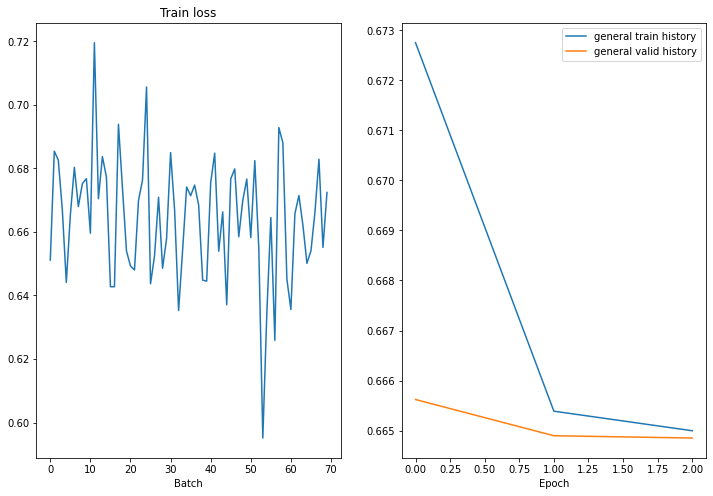

Epoch: 04 | Time: 5m 11s
	Train Loss: 0.665 | Train accuracy: 0.622
	 Val Loss: 0.664 |  Val accuracy: 0.621


In [16]:
# Bert
# 1. Заморозить веса BERT и использовать его для получения признаков, а учить только классификатор

train_history = []
valid_history = []

N_EPOCHS = 4
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(bert_clf, train_loader, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss, valid_acc = evaluate(bert_clf, dev_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(bert_clf.state_dict(), 'best-val-model_Bert_1.pt')    
  
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train accuracy: {train_acc:.3f}')
    print(f'\t Val Loss: {valid_loss:.3f} |  Val accuracy: {valid_acc:.3f}')

In [16]:
from tqdm.autonotebook import tqdm

def val_predict(model, path, own_model_classifier=False):

    model.load_state_dict(torch.load(path))
    model.eval();

    preds_list = []
    targets_list = []

    pbar = tqdm(enumerate(dev_loader), total=len(dev_loader), leave=False)

    with torch.no_grad():
      for it, batch in pbar:

              inputs = batch["input_ids"].to(device)
              labels = batch['target'].to(device)
              attention_mask = batch['attention_mask'].to(device)
              token_type_ids = batch['token_type_ids'].to(device)

              outp = model(inputs, attention_mask, token_type_ids) 

              if own_model_classifier:
                  outp = outp.logits[:, 1]
                  outp = torch.sigmoid(outp) 
              preds = (outp>0.5).type(torch.long).view(-1).cpu()
              preds = preds.tolist()
              preds_list.append(preds)

              targets = labels.tolist()
              targets_list.append(targets)    

    targets_list_ = [y for x in targets_list for y in x]
    preds_list_ = [y for x in preds_list for y in x]
      
    return(accuracy_score(targets_list_, preds_list_))

In [18]:
print(val_predict(bert_clf, 'best-val-model_Bert_1.pt'))

# 0.6214067278287462 - lr=1e-5
# результат на уровне бейзлайна

  0%|          | 0/26 [00:00<?, ?it/s]

0.6214067278287462


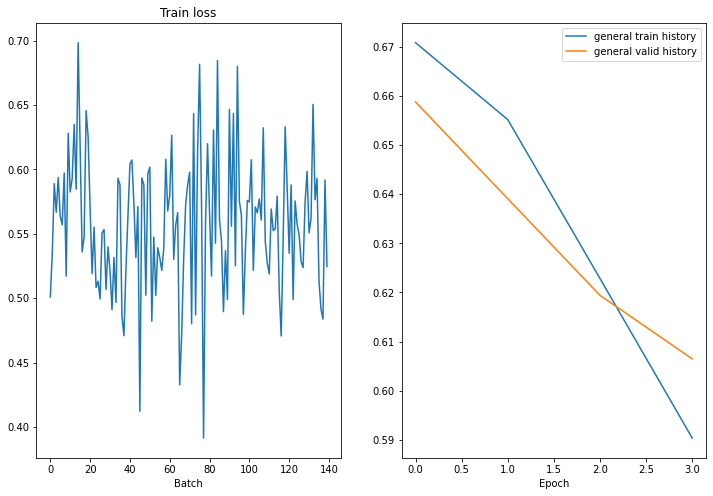

Epoch: 05 | Time: 6m 28s
	Train Loss: 0.554 | Train accuracy: 0.722
	 Val Loss: 0.611 |  Val accuracy: 0.678


In [29]:
# Bert
# 2. Разморозить pooler и 3 последних слоя BERT и учить их вместе с классификатором

train_history = []
valid_history = []

N_EPOCHS = 5
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(bert_clf, train_loader, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss, valid_acc = evaluate(bert_clf, dev_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(bert_clf.state_dict(), 'best-val-model_Bert_2.pt')    
  
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train accuracy: {train_acc:.3f}')
    print(f'\t Val Loss: {valid_loss:.3f} |  Val accuracy: {valid_acc:.3f}')

In [30]:
print(val_predict(bert_clf, 'best-val-model_Bert_2.pt'))

# 0.6758409785932722 - lr=1e-5
# результат повысился!

  0%|          | 0/52 [00:00<?, ?it/s]

0.6758409785932722


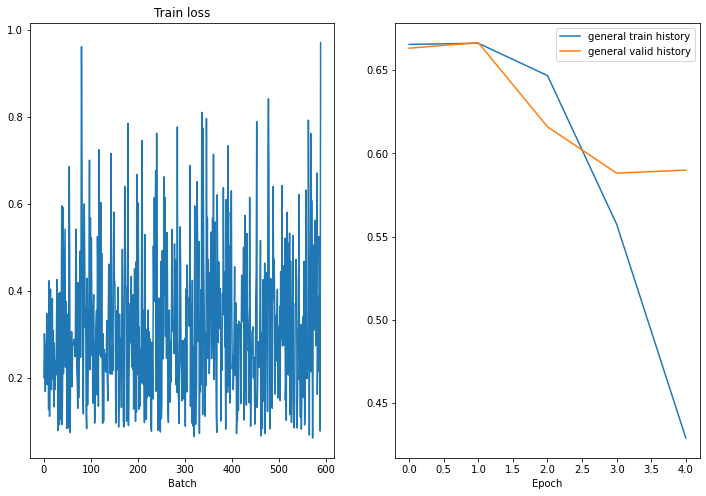

Epoch: 06 | Time: 11m 10s
	Train Loss: 0.320 | Train accuracy: 0.883
	 Val Loss: 0.669 |  Val accuracy: 0.738


In [18]:
# Bert
# 3. Заморозить веса BERT на первые 2 эпохи, в это время учить только классификатор, потом разморозить BERT и учить все вместе

train_history = []
valid_history = []

N_EPOCHS = 6
CLIP = 1

best_valid_loss = float('inf')

num_freeze_epoch = 1 # 2 эпохи учим только классификатор
freeze_parameters(bert_clf)

for epoch in range(N_EPOCHS):
    
    start_time = time.time()

    if epoch > num_freeze_epoch:
        freeze_parameters(bert_clf, True)
    
    train_loss, train_acc = train(bert_clf, train_loader, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss, valid_acc = evaluate(bert_clf, dev_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(bert_clf.state_dict(), 'best-val-model_Bert_3.pt')    
  
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train accuracy: {train_acc:.3f}')
    print(f'\t Val Loss: {valid_loss:.3f} |  Val accuracy: {valid_acc:.3f}')

In [21]:
print(val_predict(bert_clf, 'best-val-model_Bert_3.pt'))

# 0.6984709480122324 - lr=1e-5
# результат еще повысился!

  0%|          | 0/205 [00:00<?, ?it/s]

0.6984709480122324


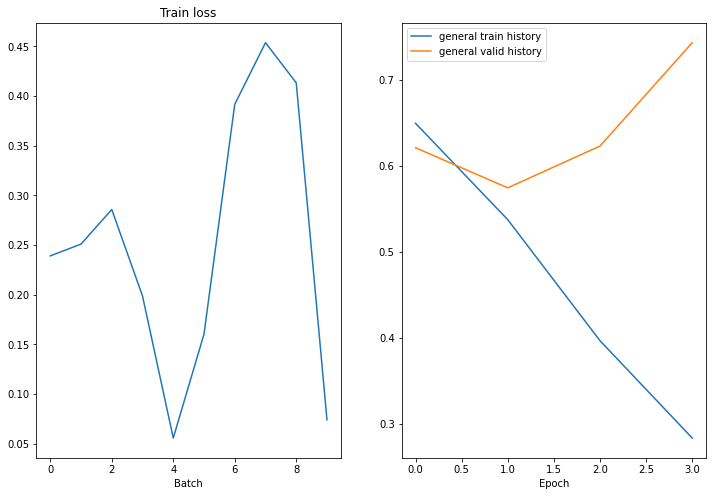

KeyboardInterrupt: ignored

In [23]:
# Bert
# 4. Сразу учить и BERT, и классификатор

train_history = []
valid_history = []

N_EPOCHS = 5
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()

    train_loss, train_acc = train(bert_clf, train_loader, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss, valid_acc = evaluate(bert_clf, dev_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(bert_clf.state_dict(), 'best-val-model_Bert_4.pt')    
  
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train accuracy: {train_acc:.3f}')
    print(f'\t Val Loss: {valid_loss:.3f} |  Val accuracy: {valid_acc:.3f}')

In [24]:
print(val_predict(bert_clf, 'best-val-model_Bert_4.pt'))

# 0.7229357798165138 - lr=1e-5, после 1 эпохи валид.лосс стал расти
# результат снова повысился! Самый лучший результат у подхода "учить одновременно и Bert, и классификатор", за 1 эпоху

  0%|          | 0/205 [00:00<?, ?it/s]

0.7229357798165138


### BertForSequenceClassification

In [10]:
model_class, tokenizer_class, pretrained_weights = (ppb.BertForSequenceClassification, ppb.BertTokenizer, 'bert-base-uncased')
tokenizer_BertForSequenceClassification = tokenizer_class.from_pretrained(pretrained_weights)
model_BertForSequenceClassification = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [11]:
train_dataset = QA_Dataset_Bert(df_train['question'].tolist(), df_train['passage'].tolist(), df_train['answer'].tolist(), tokenizer_BertForSequenceClassification) 
dev_dataset = QA_Dataset_Bert(df_dev['question'].tolist(), df_dev['passage'].tolist(), df_dev['answer'].tolist(), tokenizer_BertForSequenceClassification)

In [12]:
batch_size = 16 # для обучения модели целиком
# batch_size = 128 # для обучения только классификатора

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, drop_last=False)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size, shuffle=False, drop_last=False)

In [18]:
# model_BertForSequenceClassification

У модели есть собственный классификатор. Сравним, что будет работать лучше при 1 типе обучения (учить только классификатор) - собственный классификатор модели, или написанный вручную? 

In [14]:
# Заморозка параметров

# замораживаем параметры целиком
# model_BertForSequenceClassification = model_BertForSequenceClassification.bert

# for param in model_BertForSequenceClassification.bert.parameters():
# for param in model_BertForSequenceClassification.parameters():
#     param.requires_grad = False

# замораживаем параметры частично

# layers_to_unfreeze = 3
# for param in model_BertForSequenceClassification.encoder.layer[-layers_to_unfreeze:].parameters():
#     param.requires_grad = True

# def freeze_parameters(model, req_grad=False):
#     freezing_part = model.bert
#     for c_p in freezing_part.parameters():
#         c_p.requires_grad = req_grad

In [15]:
# for param in model_BertForSequenceClassification.parameters():
#     if param.requires_grad:
#         print(param.shape)

In [15]:
class BertForSequenceClassificationforQA(nn.Module):
    def __init__(self, pretrained_model, dropout=0.2):
        super().__init__()

        self.bert = pretrained_model
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
        self.fc_0 = nn.Linear(768, 384)
        self.fc_1 = nn.Linear(384, 1)
    
    def forward(self, inputs, attention_mask, token_type_ids):

        outp = self.bert(inputs, attention_mask, token_type_ids) 
        outp = outp[0][:, 0, :] # токен CLS 
        outp = self.relu(self.fc_0(self.dropout(outp))) 
        outp = self.fc_1(self.dropout(outp))
        proba = torch.sigmoid(outp).squeeze(1)  

        return proba

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_BertForSequenceClassification = model_BertForSequenceClassification.to(device)
# BertForSequenceClassification_clf = BertForSequenceClassificationforQA(model_BertForSequenceClassification).to(device)

optimizer = optim.AdamW(model_BertForSequenceClassification.parameters(), lr=1e-5)
criterion = nn.BCELoss()
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

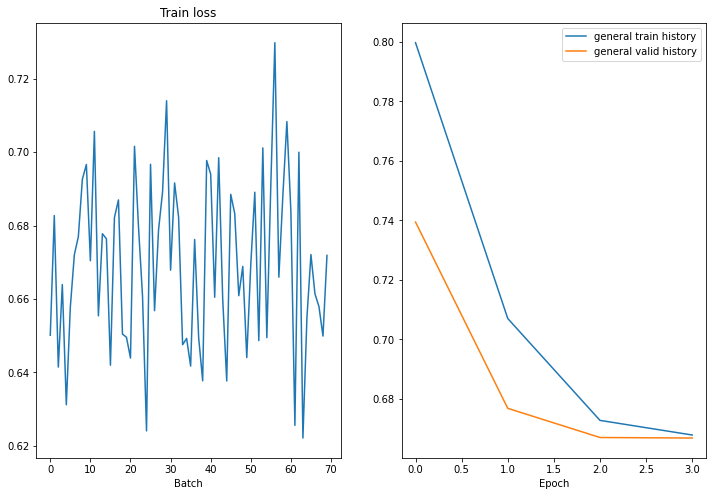

Epoch: 05 | Time: 5m 9s
	Train Loss: 0.670 | Train accuracy: 0.618
	 Val Loss: 0.667 |  Val accuracy: 0.620


In [22]:
# BertForSequenceClassification
# 1. Заморозить веса BERT и использовать его для получения признаков, а учить только классификатор
# Учим классификатор МОДЕЛИ! own_model_classifier=True

train_history = []
valid_history = []

N_EPOCHS = 5
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model_BertForSequenceClassification, train_loader, optimizer, criterion, 
                                  CLIP, train_history, valid_history, own_model_classifier=True)
    valid_loss, valid_acc = evaluate(model_BertForSequenceClassification, dev_loader, criterion, own_model_classifier=True)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_BertForSequenceClassification.state_dict(), 'best-val-model_BertForSequenceClassification_1_1.pt')    
  
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train accuracy: {train_acc:.3f}')
    print(f'\t Val Loss: {valid_loss:.3f} |  Val accuracy: {valid_acc:.3f}')

In [26]:
print(val_predict(model_BertForSequenceClassification, 'best-val-model_BertForSequenceClassification_1_1.pt', own_model_classifier=True))

# 0.6198776758409786 - lr=1e-5, 5 эпох, классификатор модели
# чуть меньше бейзлайна

  0%|          | 0/26 [00:00<?, ?it/s]

0.6198776758409786


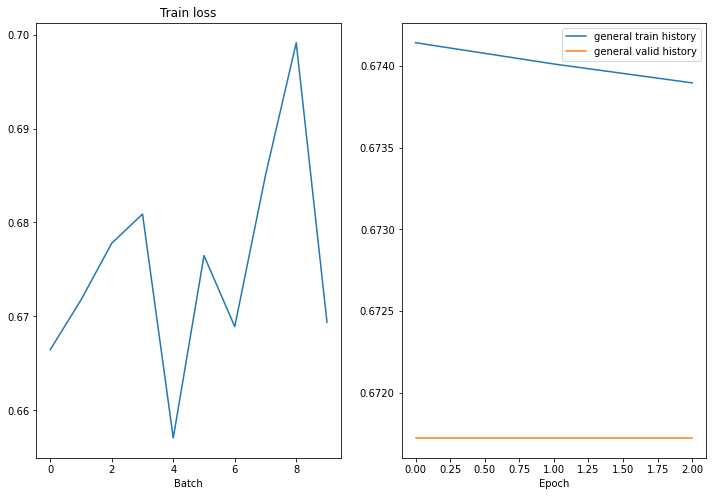

KeyboardInterrupt: ignored

In [17]:
# BertForSequenceClassification
# 1. Заморозить веса BERT и использовать его для получения признаков, а учить только классификатор
# Учим СВОЙ классификатор!

train_history = []
valid_history = []

N_EPOCHS = 5
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(BertForSequenceClassification_clf, train_loader, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss, valid_acc = evaluate(BertForSequenceClassification_clf, dev_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(BertForSequenceClassification_clf.state_dict(), 'best-val-model_BertForSequenceClassification_1_2.pt')    
  
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train accuracy: {train_acc:.3f}')
    print(f'\t Val Loss: {valid_loss:.3f} |  Val accuracy: {valid_acc:.3f}')

In [18]:
print(val_predict(BertForSequenceClassification_clf, 'best-val-model_BertForSequenceClassification_1_2.pt'))

# 0.6217125382262997 - lr=1e-5, 3 эпохи, свой классификатор
# на уровне бейзлайна

  0%|          | 0/26 [00:00<?, ?it/s]

0.6217125382262997


Хотя собственный классификатор модели показал качество чуть ниже, чем написанный вручную, но он показывал адекватную кривую обучения. Поэтому для других типов обучения скорее стоит использовать собственный классификатор модели. 
И поскольку на модели Bert лучше всего показал 4 способ обучения (учить одновременно и Bert, и классификатор), то попробуем дальше именно его. И используем sheduler, чтобы не переобучиться также быстро, как это случилось с Bert при 4 способе обучения.

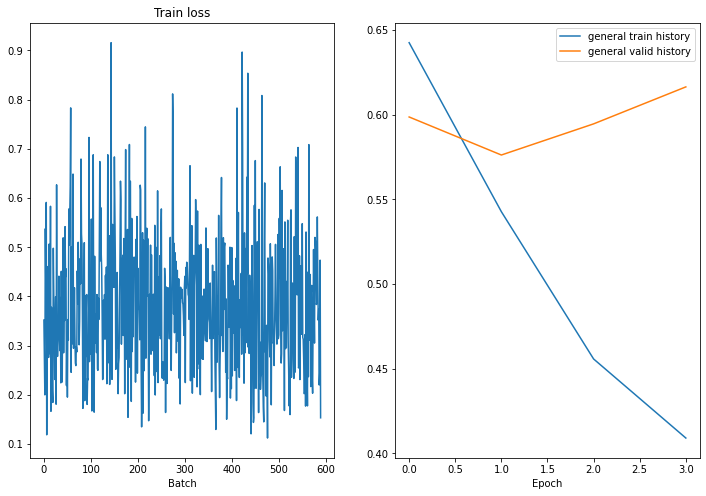

Epoch: 05 | Time: 11m 10s
	Train Loss: 0.382 | Train accuracy: 0.834
	 Val Loss: 0.630 |  Val accuracy: 0.711


In [14]:
# BertForSequenceClassification
# 4. Сразу учить и BERT, и классификатор
# Учим классификатор МОДЕЛИ! own_model_classifier=True

train_history = []
valid_history = []

N_EPOCHS = 5
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()

    train_loss, train_acc = train(model_BertForSequenceClassification, train_loader, optimizer, criterion, 
                                  CLIP, train_history, valid_history, lr_sched=True, own_model_classifier=True)
    valid_loss, valid_acc = evaluate(model_BertForSequenceClassification, dev_loader, criterion, own_model_classifier=True)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_BertForSequenceClassification.state_dict(), 'best-val-model_BertForSequenceClassification_4.pt')    
  
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train accuracy: {train_acc:.3f}')
    print(f'\t Val Loss: {valid_loss:.3f} |  Val accuracy: {valid_acc:.3f}')

In [17]:
print(val_predict(model_BertForSequenceClassification, 'best-val-model_BertForSequenceClassification_4.pt', own_model_classifier=True))

# 0.7201834862385321 - lr=1e-5, StepLR(step_size=2, gamma=0.5), снова переобучение после 1 эпохи!
# результат чуть хуже (в третьем знаке после запятой), чем у модели Bert с собственным классификатором, обученной также 4 способом

# 0.7045871559633028 - lr=1e-5, StepLR(step_size=1, gamma=0.5)
# результат хуже, уменьшение шага для StepLR с 2 до 1 не улучшило ситуацию

  0%|          | 0/205 [00:00<?, ?it/s]

0.7045871559633028


### RobertaForSequenceClassification

Для модели RobertaForSequenceClassification рассмотрим только 4 способ обучения с использованием собственного классификатора модели.

In [6]:
model_class, tokenizer_class, pretrained_weights = (ppb.RobertaForSequenceClassification, ppb.RobertaTokenizer, 'roberta-base')
tokenizer_Roberta = tokenizer_class.from_pretrained(pretrained_weights)
model_Roberta = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [7]:
# без token_type_ids

class QA_Dataset_Roberta(torch.utils.data.Dataset):
    def __init__(self, question, passage, labels, tokenizer, max_length=512):
        self.question = question
        self.passage = passage
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.labels = labels

    def __getitem__(self, idx):
  
        que = self.question[idx]
        pas = self.passage[idx]
        target = self.labels[idx]

        # 512 - the specified maximum sequence length for this model, 3 токена - cls и 2 sep, 512-3=509
        # почему-то выставления max_length в tokenizer.encode_plus было не достаточно, попадались батчи с последовательностями большей длины
        if len(self.tokenizer.tokenize(que)) + len(self.tokenizer.tokenize(pas)) > 509:
               pas = pas[:509-len(self.tokenizer.tokenize(que))]

        tokenizer_output = self.tokenizer.encode_plus(que, pas, max_length=self.max_length, 
                                                 padding="max_length", 
                                                 return_tensors="pt")

        return {
            "input_ids": tokenizer_output['input_ids'][0], 
            "attention_mask": tokenizer_output['attention_mask'][0],
            'target': torch.tensor(target, dtype=torch.float32)
        }

    def __len__(self):
        return len(self.labels)

In [8]:
train_dataset = QA_Dataset_Roberta(df_train['question'].tolist(), df_train['passage'].tolist(), df_train['answer'].tolist(), tokenizer_Roberta) 
dev_dataset = QA_Dataset_Roberta(df_dev['question'].tolist(), df_dev['passage'].tolist(), df_dev['answer'].tolist(), tokenizer_Roberta)

In [9]:
batch_size = 16 # для обучения модели целиком

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, drop_last=False)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size, shuffle=False, drop_last=False)

In [19]:
# model_Roberta

In [17]:
# без token_type_ids

def train_Roberta(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None, own_model_classifier=False, lr_sched=False):
    model.train()
    
    epoch_loss = 0
    history = []
    preds_list = []
    targets_list = []

    for i, batch in enumerate(iterator):
        
        inputs = batch["input_ids"].to(device)
        labels = batch['target'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        optimizer.zero_grad()
        
        outp = model(inputs, attention_mask)
        if own_model_classifier:
              outp = outp.logits[:, 1]
              outp = torch.sigmoid(outp) 

        loss = criterion(outp, labels) 
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        preds = (outp>0.5).type(torch.long).view(-1).cpu()
        preds = preds.tolist()
        preds_list.append(preds)
        targets = labels.tolist()
        targets_list.append(targets)
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            plt.show()

    targets_list_ = [y for x in targets_list for y in x]
    preds_list_ = [y for x in preds_list for y in x]  
    acc = accuracy_score(targets_list_, preds_list_)  

    if lr_sched:
        lr_scheduler.step()

    return epoch_loss / (i + 1), acc

def evaluate_Roberta(model, iterator, criterion, own_model_classifier=False):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    preds_list = []
    targets_list = []

    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            inputs = batch["input_ids"].to(device)
            labels = batch['target'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outp = model(inputs, attention_mask)
            if own_model_classifier:
                  outp = outp.logits[:, 1]
                  outp = torch.sigmoid(outp)

            loss = criterion(outp, labels)

            preds = (outp>0.5).type(torch.long).view(-1).cpu()
            preds = preds.tolist()
            preds_list.append(preds)
            targets = labels.tolist()
            targets_list.append(targets)
            
            epoch_loss += loss.item()

    targets_list_ = [y for x in targets_list for y in x]
    preds_list_ = [y for x in preds_list for y in x]  
    acc = accuracy_score(targets_list_, preds_list_) 
        
    return epoch_loss / (i + 1), acc

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_Roberta = model_Roberta.to(device)
optimizer = optim.AdamW(model_Roberta.parameters(), lr=1e-5)
criterion = nn.BCELoss()
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

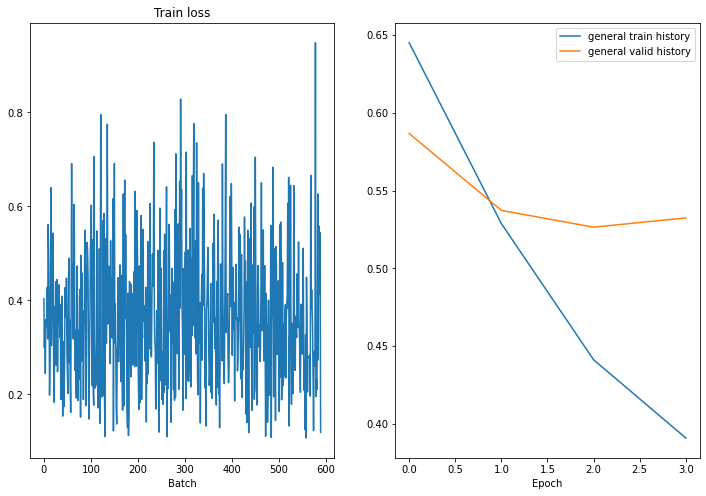

Epoch: 05 | Time: 10m 18s
	Train Loss: 0.363 | Train accuracy: 0.851
	 Val Loss: 0.536 |  Val accuracy: 0.764


In [20]:
# RobertaForSequenceClassification
# 4. Сразу учить и BERT, и классификатор
# Учим классификатор МОДЕЛИ! own_model_classifier=True

train_history = []
valid_history = []

N_EPOCHS = 5
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train_Roberta(model_Roberta, train_loader, optimizer, criterion, 
                                  CLIP, train_history, valid_history,lr_sched=True, own_model_classifier=True)
    valid_loss, valid_acc = evaluate_Roberta(model_Roberta, dev_loader, criterion, own_model_classifier=True)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_Roberta.state_dict(), 'best-val-model_Roberta_4.pt')       
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train accuracy: {train_acc:.3f}')
    print(f'\t Val Loss: {valid_loss:.3f} |  Val accuracy: {valid_acc:.3f}')

In [21]:
# без token_type_ids

from tqdm.autonotebook import tqdm

def val_predict_Roberta(model, path, own_model_classifier=False):

    model.load_state_dict(torch.load(path))
    model.eval();

    preds_list = []
    targets_list = []

    pbar = tqdm(enumerate(dev_loader), total=len(dev_loader), leave=False)

    with torch.no_grad():
      for it, batch in pbar:

              inputs = batch["input_ids"].to(device)
              labels = batch['target'].to(device)
              attention_mask = batch['attention_mask'].to(device)

              outp = model(inputs, attention_mask) 

              if own_model_classifier:
                  outp = outp.logits[:, 1]
                  outp = torch.sigmoid(outp) 
              preds = (outp>0.5).type(torch.long).view(-1).cpu()
              preds = preds.tolist()
              preds_list.append(preds)

              targets = labels.tolist()
              targets_list.append(targets)    

    targets_list_ = [y for x in targets_list for y in x]
    preds_list_ = [y for x in preds_list for y in x]
      
    return(accuracy_score(targets_list_, preds_list_))

In [22]:
print(val_predict_Roberta(model_Roberta, 'best-val-model_Roberta_4.pt', own_model_classifier=True))

# 0.7574923547400612 - lr=1e-5, StepLR(step_size=1, gamma=0.5)
# самый лучший результат!

  0%|          | 0/205 [00:00<?, ?it/s]

0.7574923547400612


## Часть 5. BiDAF-подобная архитектура (2 балла)

Архитектура BiDAF является специфической архитектурой для QA. Здесь вам предлагается её реализовать.

Основана на статье: Bidirectional Attention Flow for Machine Comprehension

Minjoon Seo, Aniruddha Kembhavi, Ali Farhadi, Hannaneh Hajishirzi

https://arxiv.org/abs/1611.01603

Архитектура BiDAF предложена для задачи SQuAD, но легко может быть адаптирована к текущему заданию. Модель состоит из следующих блоков:
1. Кодировщик  получает на вход два представления слова: эмбеддинг слова и полученное из CNN посимвольное представление слова. Кодировщики для вопроса и для параграфа одинаковы. 
2. Слой внимания (детальное описание приведено в статье, см. пункт Attention Flow Layer)
3. Промежуточный слой, который получает на вход контекстуализированные эмбеддинги слов из параграфа, состоящие из трех частей (выход кодировщика параграфа,   Query2Context (один вектор) и Context2Query (матрица) выравнивания

4. Слой предсказания. 

Предложите, как можно было модифицировать последний слой предсказания в архитектуре BiDAF, с учетом того, что итоговое предсказание – это метка yes / no, предсказание которой проще, чем предсказание спана ответа для SQuAD.

Оцените качество этой модели для решения задачи. 

[bonus] Замените входные эмбеддинги и все дополнительные признаки, используемые кодировщиками, на BERT или RoBERTa эмбеддинги. Улучшит ли это качество результатов?

Сравнение DrQA и BiDAF:
    
![](https://www.researchgate.net/profile/Felix_Wu6/publication/321069852/figure/fig1/AS:560800147881984@1510716582560/Schematic-layouts-of-the-BiDAF-left-and-DrQA-right-architectures-We-propose-to.png)

## Часть 6. Итоги (2 балла)
Напишите краткое резюме проделанной работы. Сравните результаты всех разработанных моделей. Что помогло вам в выполнении работы, чего не хватало?

В работе на корпусе BoolQ были опробованы несколько моделей для задачи Question Answering, предполагающей бинарный ответ (да/нет). 

Исходный бейзлайн - присвоить всем объектам самый частый класс из train части, т.е. ответ "да". Этот подход давал accuracy в 0.6217.

Алгоритм fasttext показал accuracy 0.6734, и он работал лучше не необработанных данных, чем на текстах с предобработкой.

Идея получить BERT эмбеддинги вопроса и абзаца, а затем обучить логистическую регрессию на их конкатенации, сработала немного хуже предыдущей модели - accuracy 0.6636 против 0.6734 у fasttext. При этом регистронезависимые эмбединги в среднем давали чуть лучше результаты, чем регистрочувствительные.

Больше всего попрактиковаться получилось с подходом взять предобученный BERT/RoBERTa и добавить свои полносвязные "головные" слои или использовать уже имеющийся у модели классификатор, если он есть. Использовалось 4 способа обучения:

1. Заморозить веса BERT/RoBERTa и использовать его для получения признаков, а учить только классификатор
2. Разморозить несколько последних слоев BERT/RoBERTa и учить их вместе с классификатором
3. Заморозить веса BERT/RoBERTa на первые несколько эпох, в это время учить только классификатор, потом разморозить BERT/RoBERTa и учить все вместе
4. Сразу учить и BERT/RoBERTa, и классификатор

К сожалению, не получилось организовать время так, чтобы опробовать все 4 подхода на каждой из выбранных моделей (BertModel, BertForSequenceClassification, RobertaForSequenceClassification). Поэтому на первой модели - BertModel - были рассмотрены все способы, и сделан вывод, что они расположены в порядке повышения accuracy (1 сп. - 0.6214, 2 сп. - 0.6758, 3 сп. - 0.6985, 4 сп. - 0.7229). Так что остальные модели обучались только 4 способом. 

Единственное, поскольку и у BertForSequenceClassification, и у RobertaForSequenceClassification есть собственные классификаторы, то для BertForSequenceClassification еще был рассмотрен 1 способ обучения в двух вариантах - с собственным классификатором и с классификатором, написанным вручную. Это было сделано для того, чтобы выбрать, какой вариант использовать при 4 способе обучения. Вероятно, оптимальнее было бы проверить эти два варианта сразу на 4 способе обучения, но также хотелось посмотреть, будет ли 1 способ обучения лучше работать у модели, отличной от Bert. И этот эксперимент показал, что обе модели BertForSequenceClassification - и с собственным классификатором, и с классификатором, написанным вручную - дают при 1 способе обучения качество, как и в случае с Bert - на уровне бейзлайна. Но поскольку модель с собственным классификатором показала более крутую кривую обучения, то для эксперимента с 4 способом была выбрана именно она. 

Итог: accuracy 0.7201 у BertForSequenceClassification (чуть ниже, чем у Bert в 4 способе), и accuracy 0.7575 у RobertaForSequenceClassification. Таким образом модель RobertaForSequenceClassification  с собственным классификатором, обученная 4 способом - сразу учить и RoBERTa, и классификатор - стала победителем данного исследования. 